In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from edca_analysis.sdca_gaussian_exogenous import SupervisedDCA as SDCAe
import pickle
from scipy.stats import boxcox

from edca_analysis.plot_utils import axplot_imshow, append_marginal_axis
from edca_analysis.analysis import calculate_leverage_score

In [3]:
DATA_DIR = "../OFC_data/"
IMG_DIR = "./images/EC125"
os.makedirs(IMG_DIR, exist_ok=True)
fn = "v7_EC125_TimeAveragedSpectraPower_6mA_FreqBands.pkl"
patient = fn.split("_")[1]
current = [i for i in fn.split("_") if "mA" in i][0]
savefig = False
patient, current

('EC125', '6mA')

In [4]:
with open(f"{DATA_DIR}/{fn}", "rb") as f:
    data_dict = np.load(f, allow_pickle=True).item()

In [5]:
power = data_dict["power_stim"]
freqs = data_dict["freqs"]
finalVerifiedChanNames = data_dict["finalVerifiedChanNames"]
finalVerifiedRegions = data_dict["finalVerifiedRegions"]
regionNames = data_dict["regionNames"]

print(power.shape)
cutoff_freq = 28
cutoff_idx = np.where(freqs > cutoff_freq)[0][0]
power = power[:, :cutoff_idx]
print(cutoff_idx)
freqs = freqs[:cutoff_idx]
print(power.shape)

(17, 31, 224964)
20
(17, 20, 224964)


In [6]:
finalVerifiedChanNames, finalVerifiedRegions, regionNames

(array(['AOF1', 'AOF4', 'POF2', 'AD2', 'AD3', 'AD4', 'HD2', 'HD3', 'SC3',
        'SC4', 'IC2', 'IC3', 'IND1', 'IND2', 'IND3', 'IND4', 'IND5'],
       dtype='<U4'),
 array([1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 6, 6, 6], dtype=uint8),
 array(['OFC', 'Amygdala', 'Hippocampus', 'SuperiorCingulate',
        'InferiorCingulate', 'Insula'], dtype='<U17'))

In [7]:
Fs = data_dict["Fs"]
dsFs = data_dict["dsFs"]
# stim_start = int(np.floor(int(1.0 * data_dict["stimStartSample"]) * dsFs / Fs))
# stim_end = int(np.floor(int(1.0 * data_dict["stimEndSample"]) * dsFs / Fs))

stim_start = int(1.0 * data_dict["stimStartSample"])
stim_end = int(1.0 * data_dict["stimEndSample"])

print(stim_start, stim_end)
print(stim_start / dsFs, stim_end / dsFs)

12972 131088
25.3359375 256.03125


In [83]:
1 / dsFs * 5

0.009765625

# Region 1

In [58]:
region = "Amygdala"
region_idx = np.where(np.array(regionNames) == region)[0][0] + 1
chan_idx = np.where(np.array(finalVerifiedRegions) == region_idx)[0]
chan_idx, region_idx

(array([3, 4, 5]), 2)

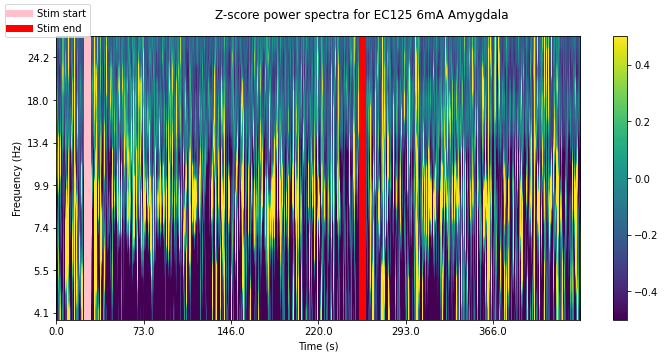

In [59]:
fig, ax = plt.subplots(figsize=(10, 5))
# this is spectrogram of one electrode (or averaged), dimensions (freq, time)
plt_data = np.mean(power[chan_idx], axis=0)  # average over electrodes in OFC
# plt_data = power[0]  # one electrode in OFC

# take z-score of power spectra before stim
plt_data = (
    plt_data - np.mean(plt_data[:, :stim_start], axis=1, keepdims=True)
) / np.std(plt_data[:, :stim_start], axis=1, keepdims=True)

im = ax.imshow(
    plt_data, aspect="auto", cmap="viridis", vmin=-0.5, vmax=0.5
)  # plot lower frequency at bottom
ax.axvline(stim_start, color="pink", lw=7, label="Stim start")
ax.axvline(stim_end, color="red", lw=7, label="Stim end")
fig.colorbar(im, ax=ax)
ax.invert_yaxis()
y_steps = 6
chosen_indices = np.arange(0, len(power[0]))[:: len(power[0]) // (y_steps)]
ax.set_yticks(chosen_indices)
ax.set_yticklabels(np.round([freqs[i] for i in chosen_indices], 1))
time_steps = 6
time_indices = np.arange(0, len(plt_data[0]))[:: len(plt_data[0]) // (time_steps)]
ax.set_xticks(time_indices)
ax.set_xticklabels(np.round([i / dsFs for i in time_indices]))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
# ax.set_title(f"{finalVerifiedChanNames[0]}")

title = f"Z-score power spectra for {patient} {current} {region}"
fig.suptitle(f"{title}")
fig.legend(loc="upper left")
fig.tight_layout()
savefig = False
if savefig:
    fig.savefig(f"{IMG_DIR}/{title}.png", facecolor="white", transparent=False, dpi=300)

In [60]:
# curr_pow = np.mean(power[chan_idx], axis=0)
curr_pow = power[chan_idx]
curr_pow = np.stack(curr_pow, axis=1).reshape(-1, curr_pow.shape[-1])
transformed = [boxcox(curr_power[:stim_start]) for curr_power in curr_pow]
boxcox_lambda = [second for (first, second) in transformed]
np.round(boxcox_lambda, 3)

array([0.101, 0.161, 0.228, 0.102, 0.22 , 0.314, 0.109, 0.297, 0.382,
       0.152, 0.26 , 0.358, 0.167, 0.248, 0.329, 0.162, 0.241, 0.291,
       0.183, 0.235, 0.267, 0.221, 0.246, 0.305, 0.243, 0.254, 0.243,
       0.228, 0.233, 0.239, 0.201, 0.196, 0.209, 0.203, 0.179, 0.197,
       0.107, 0.197, 0.23 , 0.117, 0.163, 0.202, 0.09 , 0.144, 0.195,
       0.073, 0.131, 0.187, 0.105, 0.15 , 0.185, 0.12 , 0.148, 0.185,
       0.086, 0.104, 0.173, 0.046, 0.074, 0.123])

In [61]:
data = np.array(
    [
        boxcox(curr_power, lmbda=boxcox_lambda[i])
        for i, curr_power in enumerate(curr_pow)
    ]
)

In [62]:
data = (data - np.mean(data[:, :stim_start], axis=1, keepdims=True)) / np.std(
    data[:, :stim_start], axis=1, keepdims=True
)
data = data.T
print(data.shape)

(224964, 60)


## Region 2 (All other regions)

In [63]:
np.where(np.array(regionNames) != region)[0]

array([0, 2, 3, 4, 5])

In [85]:
os.path.splitext(fn)[0]

'v7_EC125_TimeAveragedSpectraPower_6mA_FreqBands'

In [64]:
# Splitting remaining electrodes into their own regions.
# Then curr_pow is of order (region, freq, time) concatenated across regions
remaining_region_idx = np.where(np.array(regionNames) != region)[0]
curr_pow2 = []
for i in remaining_region_idx:
    print(regionNames[i])
    temp_chan2_idx = np.where(np.array(finalVerifiedRegions) == i + 1)[0]
    print(temp_chan2_idx)
    temp_curr_pow2 = power[temp_chan2_idx]
    temp_curr_pow2 = np.stack(temp_curr_pow2, axis=1).reshape(
        -1, temp_curr_pow2.shape[-1]
    )
    curr_pow2.append(temp_curr_pow2)

curr_pow2 = np.concatenate(curr_pow2, axis=0)
print(curr_pow2.shape)
transformed2 = [boxcox(curr_power[:stim_start]) for curr_power in curr_pow2]
boxcox_lambda = [second for (first, second) in transformed2]
np.round(boxcox_lambda, 3)[:5]
# region2_idx = np.where(np.array(regionNames) == region)[0][0] + 1
# chan2_idx = np.where(np.array(finalVerifiedRegions) != region2_idx)[0]

OFC
[0 1 2]
Hippocampus
[6 7]
SuperiorCingulate
[8 9]
InferiorCingulate
[10 11]
Insula
[12 13 14 15 16]
(280, 224964)


array([0.109, 0.027, 0.109, 0.139, 0.033])

In [65]:
data2 = np.array(
    [
        boxcox(curr_power, lmbda=boxcox_lambda[i])
        for i, curr_power in enumerate(curr_pow2)
    ]
)

In [66]:
data2 = (data2 - np.mean(data2[:, :stim_start], axis=1, keepdims=True)) / np.std(
    data2[:, :stim_start], axis=1, keepdims=True
)
data2 = data2.T
print(data2.shape)

(224964, 280)


## Fit eDCA

In [67]:
def get_xdca_projections(X, U, T, d, d_exo, rng_or_seed=0):

    sdcae_model = SDCAe(d=d, d_exo=d_exo, T=T, rng_or_seed=rng_or_seed)
    sdcae_model.fit(X, U)
    V_sdcae = sdcae_model.coef_
    V_sdcae_exo = sdcae_model.coef_exogenous_

    return sdcae_model, V_sdcae, V_sdcae_exo

In [68]:
d = 3
d_exo = 10
T = 10

sdcae_model, V, V_exo = get_xdca_projections(
    data, data2, T=T, d=d, d_exo=d_exo, rng_or_seed=0
)

In [69]:
def axplot_imshow_data(
    ax,
    data,
    xmin,
    xmax,
    ymin,
    ymax,
    vmin=None,
    vmax=None,
    vmax_quantile=None,
    cmap="gray_r",
    show_ratio=0.12,
    interpolation="antialiased",
    ylabel=None,
    title=None,
):

    if vmax is None:
        if vmax_quantile is None:
            vmax = np.max(np.abs(data))
        else:
            vmax = np.quantile(np.abs(data), vmax_quantile)
    if vmin is None:
        vmin = -vmax

    im = ax.imshow(
        data.T,
        cmap=cmap,
        extent=(xmin, xmax, ymax, ymin),
        aspect=(show_ratio * (xmax - xmin) / (ymax - ymin)),
        vmin=vmin,
        vmax=vmax,
        interpolation=interpolation,
    )
    if title is not None:
        ax.set_title(title)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    ax.set_ylim((ymin, ymax))

    return im

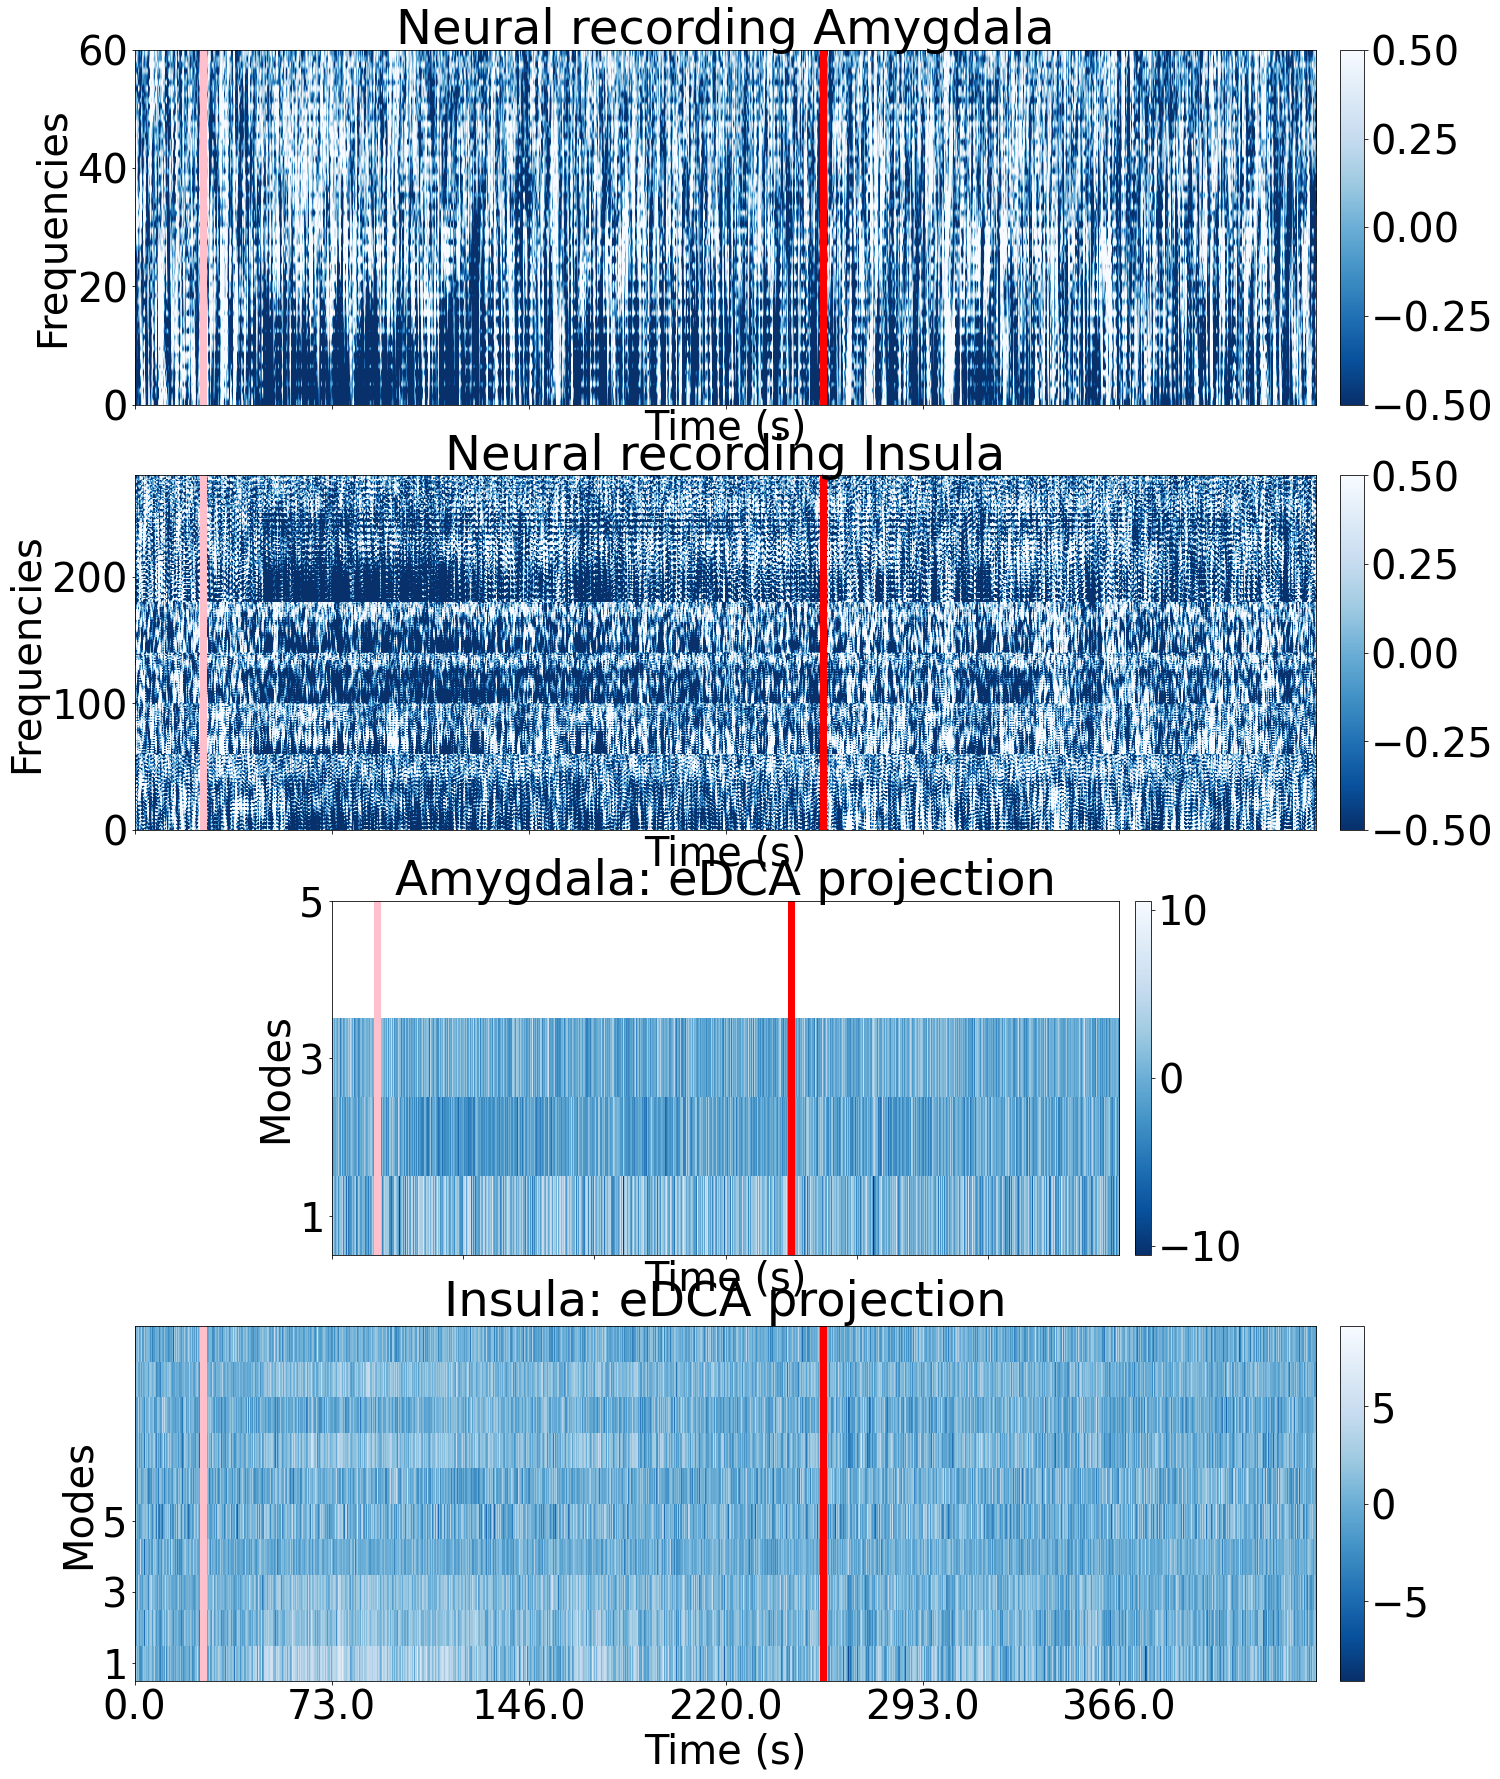

In [70]:
show_ratio = 0.3
plt.rc("font", size=40)

cb_kwargs = dict(spacing=0.02, width=0.02, which="x")

fig, axes = plt.subplots(4, 1, figsize=(30, 30), sharex=True)
# fig.subplots_adjust(top=0.3)

# --- input data ---

ax = axes[0]
im = axplot_imshow_data(
    ax,
    data,
    xmin=0,
    xmax=len(data),
    ymin=0,
    ymax=len(data[1]),
    vmin=-0.5,
    vmax=0.5,
    show_ratio=show_ratio,
    cmap="Blues_r",
    ylabel="Frequencies",
    title=f"Neural recording {region}",
)
# colorbar
cbar_ax = append_marginal_axis(ax, **cb_kwargs)
fig.colorbar(im, cax=cbar_ax)

ax = axes[1]
im = axplot_imshow_data(
    ax,
    data2,
    xmin=0,
    xmax=len(data2),
    ymin=0,
    ymax=len(data2[1]),
    show_ratio=show_ratio,
    vmin=-0.5,
    vmax=0.5,
    cmap="Blues_r",
    ylabel="Frequencies",
    # title='speech mel spectrogram',
    title=f"Neural recording {region2}",
)
# colorbar
cbar_ax = append_marginal_axis(ax, **cb_kwargs)
fig.colorbar(im, cax=cbar_ax)


# --- xDCA projections ---

V_list = [V]
titles = [f"{region}: eDCA projection"]

for ax, title, V_tmp in zip(axes[2:3], titles, V_list):
    X_proj = data @ V_tmp
    im = axplot_imshow_data(
        ax,
        X_proj,
        xmin=0,
        xmax=len(data),
        ymin=0,
        ymax=d,
        show_ratio=show_ratio,
        interpolation="none",
        cmap="Blues_r",
        ylabel="Modes",
        title=title,
    )
    ax.set_yticks([0.5, 2.5, 4.5])
    ax.set_yticklabels([1, 3, 5])
    # colorbar
    cbar_ax = append_marginal_axis(ax, **cb_kwargs)
    fig.colorbar(im, cax=cbar_ax)


ax = axes[3]
U_proj = data2 @ V_exo
im = axplot_imshow_data(
    ax,
    U_proj,
    xmin=0,
    xmax=len(data),
    ymin=0,
    ymax=d_exo,
    show_ratio=show_ratio,
    interpolation="none",
    cmap="Blues_r",
    ylabel="Modes",
    title=f"{region2}: eDCA projection",
)
ax.set_yticks([0.5, 2.5, 4.5])
ax.set_yticklabels([1, 3, 5])
# colorbar
cbar_ax = append_marginal_axis(ax, **cb_kwargs)
fig.colorbar(im, cax=cbar_ax)


# --- final annotations ---

ax.set_xlabel("Time in block (s)")
time_steps = 6
time_indices = np.arange(0, len(plt_data[0]))[:: len(plt_data[0]) // (time_steps)]

for ax in axes.ravel():
    ax.axvline(stim_start, color="pink", lw=7, label="Stim start")
    ax.axvline(stim_end, color="red", lw=7, label="Stim end")
    ax.set_xticks(time_indices)
    ax.set_xticklabels(np.round([i / dsFs for i in time_indices]))
    ax.set_xlabel("Time (s)")

# fig.suptitle(f'\'\'{sentence}\'\'', y=0.96)

fig.show()
fig.savefig(f"{IMG_DIR}/chang.png", dpi=300)

## Fitting sDCA

In [88]:
# d = 3
# d_exo = 5
# T = 10

sdcae_model2, V2, V_exo2 = get_xdca_projections(
    data, data2, T=T, d=d, d_exo=d_exo, rng_or_seed=100
)

In [94]:
data.shape

(224964, 60)

### Smaller time window, T_shift still = 10

In [104]:
sdcae_model3, V3, V_exo3 = get_xdca_projections(
    data[:-5], data2[5:], T=5, d=d, d_exo=d_exo, rng_or_seed=100
)

### Smaller time window, T_shift = 5

In [99]:
sdcae_model4, V4, V_exo4 = get_xdca_projections(
    data, data2, T=5, d=d, d_exo=d_exo, rng_or_seed=100
)

### Smaller time window, T_shift = 50

In [103]:
sdcae_model5, V5, V_exo5 = get_xdca_projections(
    data[:-50], data2[50:], T=5, d=d, d_exo=d_exo, rng_or_seed=100
)
Vs.append(V5)
V_exos.append(V_exo5)

In [105]:
Vs = [V, V2, V3, V4, V5]
V_exos = [V_exo, V_exo2, V_exo3, V_exo4, V_exo5]

### Plotting leverages

In [71]:
def axplot_label_leverage_frequency(
    V, freqs, chan_idx, ax, annotate_color="k", freq_scale=2
):
    """
    V : np.array
        projection matrix, dimensions (freq, d)
    freqs : np.array
        frequency values
    chan_idx : np.array
        channel indices to plot.
            eg. channels 1, 2, 3 belong to area OFC.
    freq_scale : int
        how often to include a freq label
    """
    for i in np.arange(0, len(V), len(chan_idx)):
        ax.axvline(i, color=annotate_color, linestyle="--", zorder=1, alpha=0.5)
    ax.set_xticks(np.arange(0, len(V), len(chan_idx) * freq_scale))
    ax.set_xticklabels(np.round(freqs[::freq_scale], 1))
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Leverage score")
    fig.show()

In [76]:
plt.rc("font", size=10)

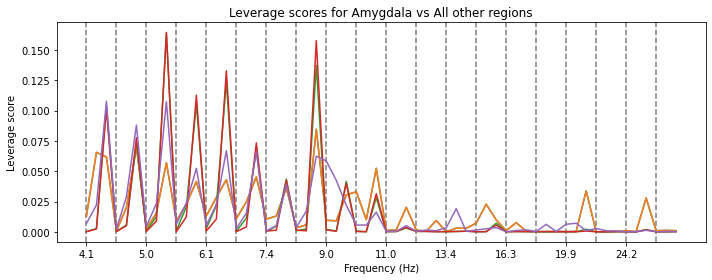

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

# ax.plot(calculate_leverage_score(V.T, average=False))
# ax.plot(calculate_leverage_score(V2.T, average=False))
# ax.plot(calculate_leverage_score(V3.T, average=False))
# ax.plot(calculate_leverage_score(V4.T, average=False))
for V_tmp in Vs:
    ax.plot(calculate_leverage_score(V_tmp.T, average=False))
axplot_label_leverage_frequency(
    V, freqs, chan_idx, ax, annotate_color="k", freq_scale=2
)
ax.set_title(f"Leverage scores for {region} vs All other regions")
fig.tight_layout()

In [78]:
remaining_region_idx = np.where(np.array(regionNames) != region)[0]
for i in remaining_region_idx:
    print(regionNames[i])
    temp_chan2_idx = np.where(np.array(finalVerifiedRegions) == i + 1)[0]
    print(temp_chan2_idx)

OFC
[0 1 2]
Hippocampus
[6 7]
SuperiorCingulate
[8 9]
InferiorCingulate
[10 11]
Insula
[12 13 14 15 16]


In [79]:
remaining_region_idx

array([0, 2, 3, 4, 5])

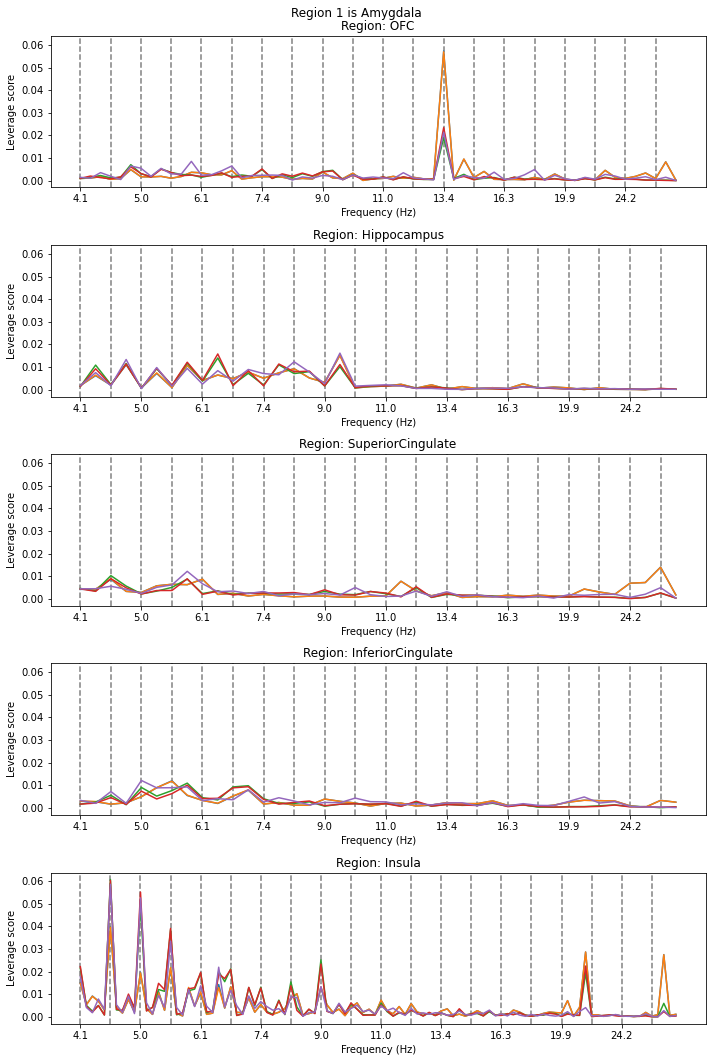

In [107]:
fig, axes = plt.subplots(len(remaining_region_idx), 1, figsize=(10, 15), sharey=True)

idx_start_count = 0
# leverage_V_exo = calculate_leverage_score(V_exo.T, average=False)
# leverage_V2_exo = calculate_leverage_score(V_exo2.T, average=False)
# leverage_V3_exo = calculate_leverage_score(V_exo3.T, average=False)
# leverage_V4_exo = calculate_leverage_score(V_exo4.T, average=False)
leverage_V_exos = [
    calculate_leverage_score(temp_V_exo.T, average=False) for temp_V_exo in V_exos
]
for i, ax in enumerate(axes):
    temp_chan2_idx = np.where(
        np.array(finalVerifiedRegions) == remaining_region_idx[i] + 1
    )[0]
    num_electrodes = len(temp_chan2_idx)
    idx_end_count = idx_start_count + num_electrodes * len(freqs)
    # leverage_region_V_exo = leverage_V_exo[idx_start_count:idx_end_count]
    # leverage_region_V2_exo = leverage_V2_exo[idx_start_count:idx_end_count]
    # leverage_region_V3_exo = leverage_V3_exo[idx_start_count:idx_end_count]
    # leverage_region_V4_exo = leverage_V4_exo[idx_start_count:idx_end_count]
    leverage_region_V_exos = [
        temp_leverage_V_exo[idx_start_count:idx_end_count]
        for temp_leverage_V_exo in leverage_V_exos
    ]
    idx_start_count = idx_end_count

    ax.set_title(f"Region: {regionNames[remaining_region_idx[i]]}")
    # ax.plot(leverage_region_V_exo)
    # ax.plot(leverage_region_V2_exo)
    # ax.plot(leverage_region_V3_exo)
    # ax.plot(leverage_region_V4_exo)
    for leverage_region_V_exo in leverage_region_V_exos:
        ax.plot(leverage_region_V_exo)
    axplot_label_leverage_frequency(
        leverage_region_V_exo,
        freqs,
        temp_chan2_idx,
        ax,
        annotate_color="k",
        freq_scale=2,
    )
fig.suptitle(f"Region 1 is {region}")
fig.tight_layout()